In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

In [2]:
# the number of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
feature_path = "./data/model_data/period_features"

def load_feature(num_period: int, feature_path: str = feature_path) -> pd.DataFrame:
    data = pd.read_parquet(f"{feature_path}/features_period_{num_period}.parquet")
    # data.iloc[:, 2:] = data.iloc[:, 2:].fillna(data.iloc[:, 2:].median())
    test_data = data.groupby("Ticker").tail(250)
    train_data = data.loc[data.index.difference(test_data.index)]
    # print(f"Loaded {num_period} period data")
    # print(f"Number of stocks: {data.Stock.nunique()}")
    # print(f"Training days: {train_data.Date.nunique()}")
    # print(f"Testing days: {test_data.Date.nunique()}")
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [19]:
train_data, test_data = load_feature(1)

X_train = train_data.drop(columns=["Date", "Ticker", "Return_tomorrow", "Target"])
y_train = train_data["Target"]
X_test = test_data.drop(columns=["Date", "Ticker", "Return_tomorrow", "Target"])
y_test = test_data["Target"]

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32, requires_grad=False)
y_test = torch.tensor(y_test.values, dtype=torch.long, requires_grad=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([236590, 31]) torch.Size([236590]) torch.Size([118000, 31]) torch.Size([118000])


In [5]:
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

stock_dataset = StockDataset(X_train, y_train)

batch_size = 256

train_loader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=True)

for features, labels in train_loader:
    print(features.shape, labels.shape)
    break

torch.Size([256, 31]) torch.Size([256])


In [6]:
# 定义 Maxout 单元
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_pieces = num_pieces
        self.linear_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) for _ in range(num_pieces)
        ])

    def forward(self, x):
        outputs = [self.linear_layers[i](x) for i in range(self.num_pieces)]
        max_output = torch.max(torch.stack(outputs), 0)[0]
        return max_output


# Network
class MaxoutNetWithRegularization(nn.Module):
    def __init__(self, dropout_input=0.1, dropout_hidden=0.5, l1_lambda=0.00001):
        super(MaxoutNetWithRegularization, self).__init__()
        self.l1_lambda = l1_lambda
        self.maxout1 = Maxout(31, 31, 2) 
        self.dropout1 = nn.Dropout(p=dropout_input)  # 输入层 dropout
        self.maxout2 = Maxout(31, 10, 2)
        self.dropout2 = nn.Dropout(p=dropout_hidden)  # 隐藏层 dropout
        self.maxout3 = Maxout(10, 5, 2)
        self.dropout3 = nn.Dropout(p=dropout_hidden)  # 隐藏层 dropout
        self.sigmoid_output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.maxout1(x)
        x = self.dropout2(x)
        x = self.maxout2(x)
        x = self.dropout3(x)
        x = self.maxout3(x)
        x = self.sigmoid_output(x)
        return x
    
    # 计算 L1 正则化损失
    def l1_regularization(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.l1_lambda * l1_loss

In [7]:
# 创建网络实例
net_with_regularization = MaxoutNetWithRegularization()
print(net_with_regularization)  # 打印网络结构

MaxoutNetWithRegularization(
  (maxout1): Maxout(
    (linear_layers): ModuleList(
      (0-1): 2 x Linear(in_features=31, out_features=31, bias=True)
    )
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (maxout2): Maxout(
    (linear_layers): ModuleList(
      (0-1): 2 x Linear(in_features=31, out_features=10, bias=True)
    )
  )
  (dropout2): Dropout(p=0.5, inplace=False)
  (maxout3): Maxout(
    (linear_layers): ModuleList(
      (0-1): 2 x Linear(in_features=10, out_features=5, bias=True)
    )
  )
  (dropout3): Dropout(p=0.5, inplace=False)
  (sigmoid_output): Linear(in_features=5, out_features=2, bias=True)
)


In [8]:
# 示例前向传播，并计算 L1 正则化损失
example_input = torch.randn(128, 31)
example_target = torch.randint(0, 2, (128,))
criteria = nn.CrossEntropyLoss()
example_output = net_with_regularization(example_input)
loss = criteria(example_output, example_target)
l1_loss = net_with_regularization.l1_regularization()
print(example_output[:2], loss, l1_loss)

tensor([[-0.5671, -0.2858],
        [-0.4758, -0.1537]], grad_fn=<SliceBackward0>) tensor(0.7368, grad_fn=<NllLossBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


In [9]:
probabilities = F.softmax(example_output, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)
print(probabilities[:2], predicted_labels[:2])

tensor([[0.4301, 0.5699],
        [0.4201, 0.5799]], grad_fn=<SliceBackward0>) tensor([1, 1])


In [10]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0.0001):
        """
        Args:
            patience (int): 耐心值，即多少个epoch没有明显改进后停止训练
            verbose (bool): 如果为True，则打印一条消息表示早停已被触发
            delta (float): 改进的最小差值，仅当改进大于等于这个值时才计算为改进
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, train_loss):
        if self.best_loss is None:
            self.best_loss = train_loss
        elif train_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("早停: 停止训练")
        else:
            self.best_loss = train_loss
            self.counter = 0

In [11]:
import torch.optim as optim
from tqdm import tqdm

dataset = StockDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

model = MaxoutNetWithRegularization()
model = model.to(device)

criteria = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

early_stopping = EarlyStopping(patience=20, verbose=True, delta=0.0001)

losses = []
gradients = []

model.train()
for epoch in range(epochs):
    epoch_losses = []
    epoch_gradients = []
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

    for inputs, targets in progress_bar:
        targets = targets.long()
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criteria(outputs, targets) + model.l1_regularization()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_gradients.append(model.maxout1.linear_layers[0].weight.grad.norm().item())

        progress_bar.set_postfix(loss=torch.mean(torch.tensor(epoch_losses)).item(), gradient=torch.mean(torch.tensor(epoch_gradients)).item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    avg_gradient = sum(epoch_gradients) / len(epoch_gradients)
    losses.append(avg_loss)
    gradients.append(avg_gradient)

    print(f"Epoch {epoch+1}, loss: {avg_loss: .4f}")
    
    early_stopping(avg_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1/10: 100%|██████████| 925/925 [00:10<00:00, 91.78it/s, gradient=0.0104, loss=0.695] 


Epoch 1, loss:  0.6954


Epoch 2/10: 100%|██████████| 925/925 [00:09<00:00, 97.28it/s, gradient=0.00705, loss=0.694] 


Epoch 2, loss:  0.6944


Epoch 3/10: 100%|██████████| 925/925 [00:09<00:00, 98.61it/s, gradient=0.00766, loss=0.694] 


Epoch 3, loss:  0.6940


Epoch 4/10: 100%|██████████| 925/925 [00:10<00:00, 92.27it/s, gradient=0.00776, loss=0.694] 


Epoch 4, loss:  0.6936


Epoch 5/10: 100%|██████████| 925/925 [00:09<00:00, 94.17it/s, gradient=0.00866, loss=0.693] 


Epoch 5, loss:  0.6934


Epoch 6/10: 100%|██████████| 925/925 [00:09<00:00, 97.30it/s, gradient=0.00857, loss=0.693] 


Epoch 6, loss:  0.6933


Epoch 7/10: 100%|██████████| 925/925 [00:09<00:00, 99.86it/s, gradient=0.00918, loss=0.693] 


Epoch 7, loss:  0.6932


Epoch 8/10: 100%|██████████| 925/925 [00:09<00:00, 98.00it/s, gradient=0.00894, loss=0.693] 


Epoch 8, loss:  0.6931


Epoch 9/10: 100%|██████████| 925/925 [00:09<00:00, 99.69it/s, gradient=0.00984, loss=0.693] 


Epoch 9, loss:  0.6931


Epoch 10/10: 100%|██████████| 925/925 [00:09<00:00, 98.77it/s, gradient=0.009, loss=0.693]   

Epoch 10, loss:  0.6930


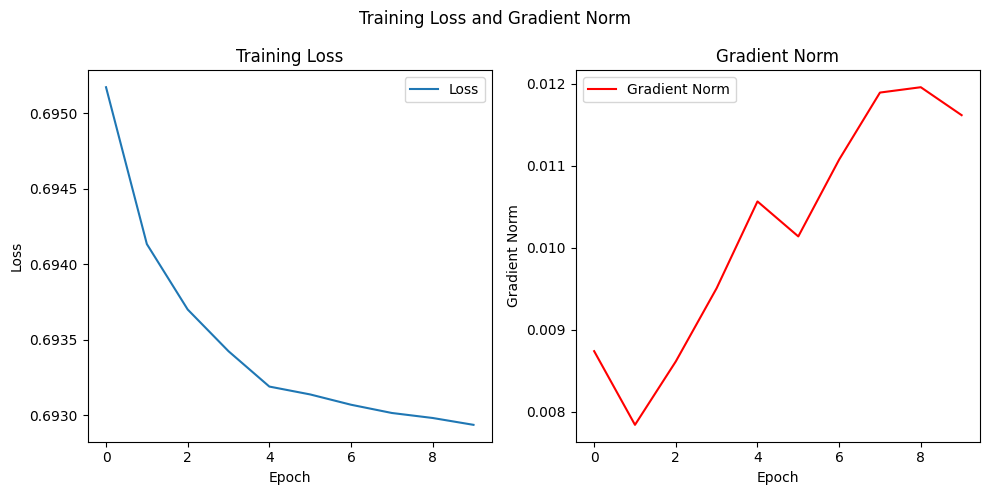

In [12]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制梯度曲线
plt.subplot(1, 2, 2)
plt.plot(gradients, label='Gradient Norm', color='red')
plt.title('Gradient Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()

plt.suptitle('Training Loss and Gradient Norm')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# predict
model.eval()

model = model.to("cpu")

with torch.no_grad():
    outputs = model(X_test)
    probabilities = F.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)
    test_loss = criteria(outputs, y_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

print(f"Test loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1: {f1:.4f}")

Test loss: 0.6924
Accuracy: 0.5142
Recall: 0.3670
Precision: 0.5156
F1: 0.4288


In [23]:
predicted_labels.numpy()

array([0, 1, 0, ..., 1, 1, 1])